# Homework (20 pts) - Hidden Markov Models

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pomegranate import *

import pandas as pd
import scipy as sp
import scipy.stats as st

%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['figure.figsize'] = (15, 5)



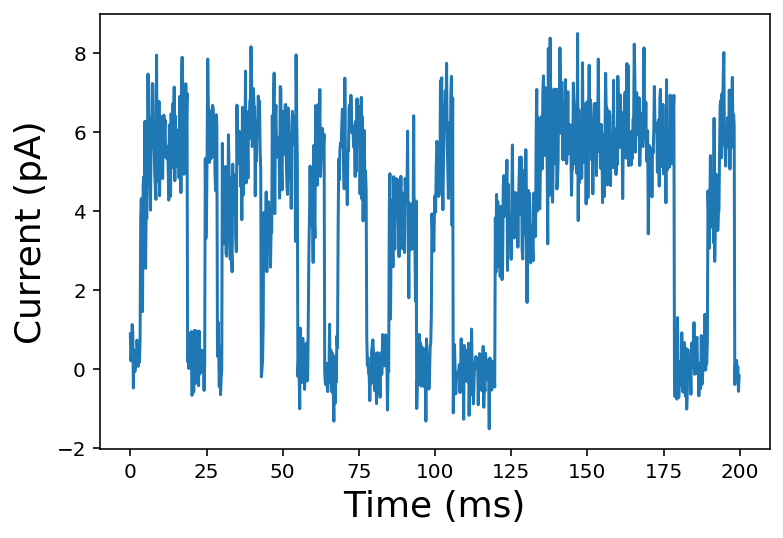

In [3]:
# single_channel.dat is located in the homework/ folder along with this notebook
with open("single_channel.dat", "rb") as f:
    time_ms, current_pA = pickle.load(f)
    time_ms = np.array(time_ms)
    current_pA = np.array(current_pA)

plt.plot(time_ms[:1000], current_pA[:1000])
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)');
# amp dist is dist of current amps
# hist of currents at every data point and plot, it will look like second part

1. (3 pts) Fit the current amplitude distribution for the entire time series to a Gaussian mixture model (GMM) with three components. Why use three components?

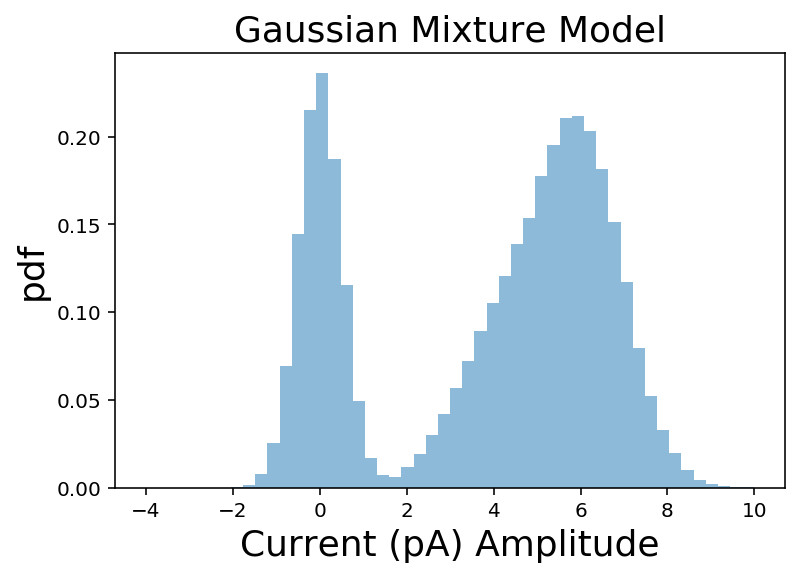

In [4]:
from sklearn.mixture import GaussianMixture
binEdges = np.linspace(-4, 10, 51)  # 51 edges -> 50 bins
gmm = GaussianMixture(n_components=3, random_state=1)

plt.hist(current_pA, bins=binEdges, alpha=0.5, density=True)

plt.xlabel('Current (pA) Amplitude')
plt.ylabel('pdf')
plt.title('Gaussian Mixture Model');

2. (3 pts) Plot a histogram of the current amplitudes (normalize to a PDF) and overlay a single PDF for each component in the GMM. Make sure you scale each of your GMM component PDFs by their fraction in the mixture.

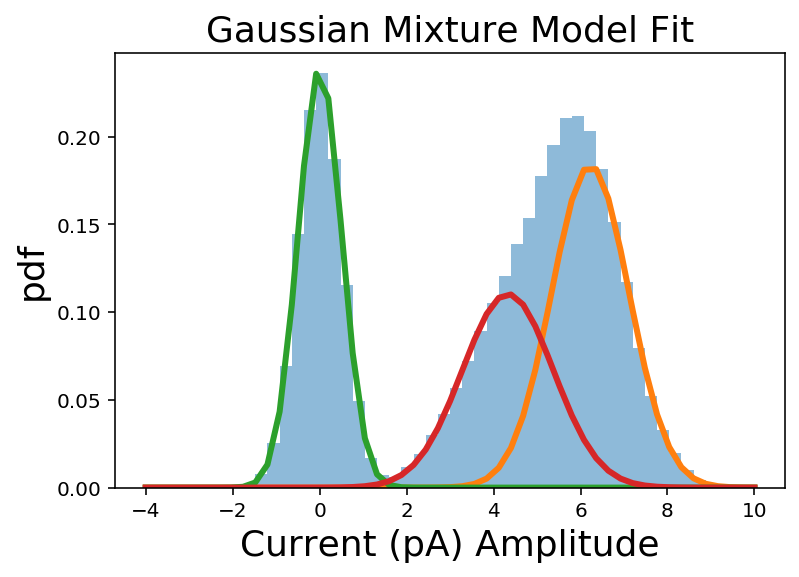

In [5]:
gmm = GaussianMixture(n_components=3, random_state=1)
# reshape is impt
gmm.fit(current_pA.reshape(-1, 1))
plt.hist(current_pA, bins=binEdges, alpha=0.5, density=True)

plt.xlabel('Current (pA) Amplitude')
plt.ylabel('pdf')
plt.title('Gaussian Mixture Model Fit');
for i in range(3):
    # weights is vector of amount of gaussian
    # mean vals and std.
    weight = gmm.weights_[i]
    mu = np.squeeze(gmm.means_)[i]
    # diagnoal component is the co variance (diag components)
    sigma = np.sqrt(np.squeeze(gmm.covariances_)[i])
    # multiplied by weight. if you add them all, you will get whole envolpe
    gmm_pdf = weight * st.norm.pdf(binEdges, mu, sigma)
    plt.plot(binEdges, gmm_pdf, lw=3)
    # density = True makes pdf match up. it would otherwise show up as counts
# broader because mixture of more states
# if you smashed everythong together, they run into each other
# takes gaussian and you specify as many as you want. so 3 levels and 3 comps
# 3 comps and fit current (array of currents). 
# many of these models expect the data to be in a certain format. like to work with cols.
# reshaped current to any number of rows and 1 cols so its treated correctlt

3. (3 pts) Plot the first 1000 data points for the current as a semitransparent line and overlay a scatter plot of the same points color-coded by the prediction of the GMM for which of the three Gaussian components the point belongs to.

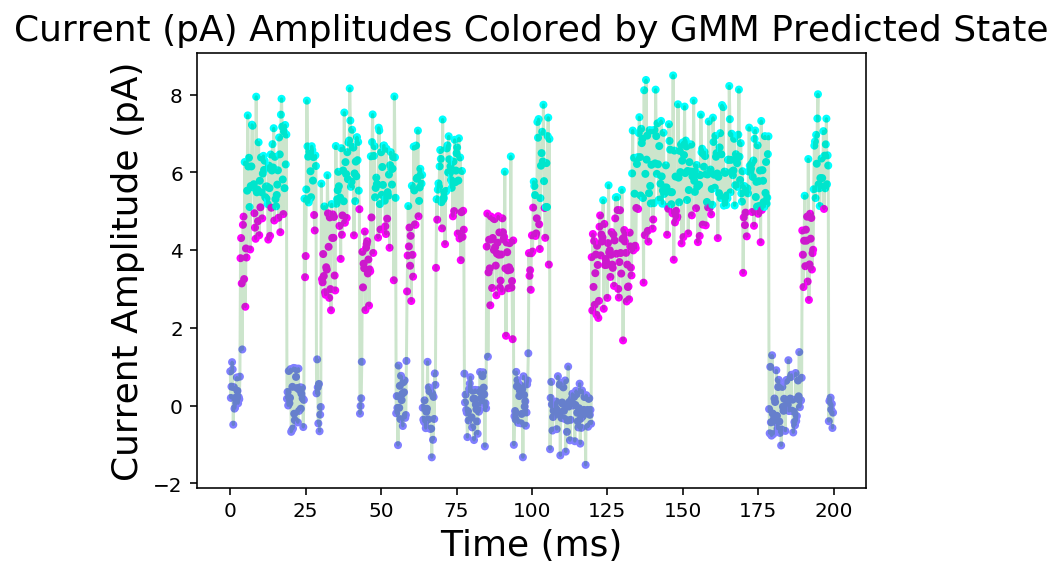

In [6]:
plt.plot(time_ms[:1000], current_pA[:1000], 'g-', alpha=0.2);
# col vector
gmm_predicted_state_seq = gmm.predict(current_pA.reshape(-1, 1))
plt.scatter(time_ms[:1000], current_pA[:1000], marker='.', c=gmm_predicted_state_seq[:1000], cmap='cool')
plt.xlabel('Time (ms)')
plt.ylabel('Current Amplitude (pA)')

plt.title('Current (pA) Amplitudes Colored by GMM Predicted State');

# plot first 1000 points and overlay with scatter plot. 
# recall that a datapoint has a prob to be in one gaussian and has small prob to be in other gaussian
# how does gmm assign label? picks the gaussian that has the highest prob
# how can hmm do better? hmm takes more params into account rather than position of current. 
# it takes into account position and seq which can help better seperate the clusters. 


4. (3 pts) Postulate an HMM with three states that might explain the current data. Build and bake this model using pomegranate. Use normally distributed state emissions.

In [7]:
import math
state0_mean = gmm.means_[1]
state1_mean = gmm.means_[2]
state2_mean = gmm.means_[0]

state0_stdev = math.sqrt(gmm.covariances_[1])
state1_stdev = math.sqrt(gmm.covariances_[2])
state2_stdev = math.sqrt(gmm.covariances_[0])


In [30]:
hmm = HiddenMarkovModel()

# create states
# state came from pom package. * means you import everything from there
state_0 = State(NormalDistribution(state0_mean, state0_stdev), name='State0')
state_1 = State(NormalDistribution(state1_mean, state1_stdev), name='State1')
state_2 = State(NormalDistribution(state2_mean, state2_stdev), name='State2')

# add states to HMM
hmm.add_states([state_0, state_1, state_2])


# recall our initial state probabilities (i.e. probability that we start off in each state)
p0 = np.array([1, 0, 0])     # P(state_0), P(state_1), P(state_2)

# we can do the same thing here by adding transition probabilities from a 'start' state to the various states in our model
hmm.add_transition(hmm.start, state_0, 1)

# recall our transition probability matrix for each time step
A = np.array([[0.30, 0.62, 0.08],     # P(0->0), P(0->1), P(0->2)
              [0.03, 0.55, 0.42],     # P(1->0), P(1->1), P(1->2)
              [0.45, 0, 0.55]])       # P(2->0), P(2->1), P(2->2)

# here, we explicitly add transitions with defined probabilities
hmm.add_transition(state_0, state_0, 0.3)  # P(C -> C) = 0.95
hmm.add_transition(state_0, state_1, 0.62)   # P(C -> O)  = 0.05
hmm.add_transition(state_0, state_2, 0.08) 

hmm.add_transition(state_1, state_0, 0.03)
hmm.add_transition(state_1, state_1, 0.55)
hmm.add_transition(state_1, state_2, 0.42)

hmm.add_transition(state_2, state_0, 0.45)
hmm.add_transition(state_2, state_2, 0.55)

# we have to bake the HMM before it is ready to use!
hmm.bake()

In [26]:
states = [state.name for state in hmm.states]
states

['State0', 'State1', 'State2', 'None-start', 'None-end']

5. (3 pts) Train/Optimize your model for the entire current trace (if this is too much for your computer, use as many points as your machine can reasonably handle). Report the optimized model parameters including the starting state probabilities, transition probabilities and state emission PDFs (these should be normal distributions, so report the means and standard deviations). **Use Pandas DataFrames to report your parameters similar to the lecture notes.**

In [27]:
# takes a list of sequences. wants it as a list
# baum iteratively adjusts params to maximize loglikelihood

hmm.fit([current_pA[:100000]], algorithm='baum-welch');

In [28]:
fit_A = pd.DataFrame(hmm.dense_transition_matrix()[:3,:3], index=states[:3], columns=states[:3])
fit_A.style.set_caption('Optimized Model Parameters')


,State0,State1,State2
State0,0.9602,0.0398002,1.41498e-11
State1,0.0106205,0.938786,0.0505931
State2,0.0195286,0,0.980471


In [29]:
start_p0 = pd.DataFrame(np.reshape(hmm.dense_transition_matrix()[3,:3], (3,1)), index=states[:3], columns=["p0"])
start_p0.style.set_caption('Starting State Probabilities')

,p0
State0,1
State1,0
State2,0


In [13]:
transition_matrix = pd.DataFrame(hmm.dense_transition_matrix()[:3,:3], index=states[:3], columns=states[:3])
transition_matrix.style.set_caption('Transition Probabilities')

,State0,State1,State2
State0,0.9602,0.0398002,1.41498e-11
State1,0.0106205,0.938786,0.0505931
State2,0.0195286,0,0.980471


In [21]:
fit_emissions = pd.DataFrame([state.distribution.parameters for state in hmm.states[:3]], index=states[:3], columns=['mean', 'std'])
fit_emissions.style.set_caption('State Emissions PDFs')

,mean,std
State0,0.00486154,0.50174
State1,4.00178,1.00016
State2,5.9934,1.00225


6. (2 pts) Plot the first 1000 data points for the current as a semitransparent line and overlay a scatter plot of the same points color-coded by the prediction of the HMM for which state each data point belongs to.

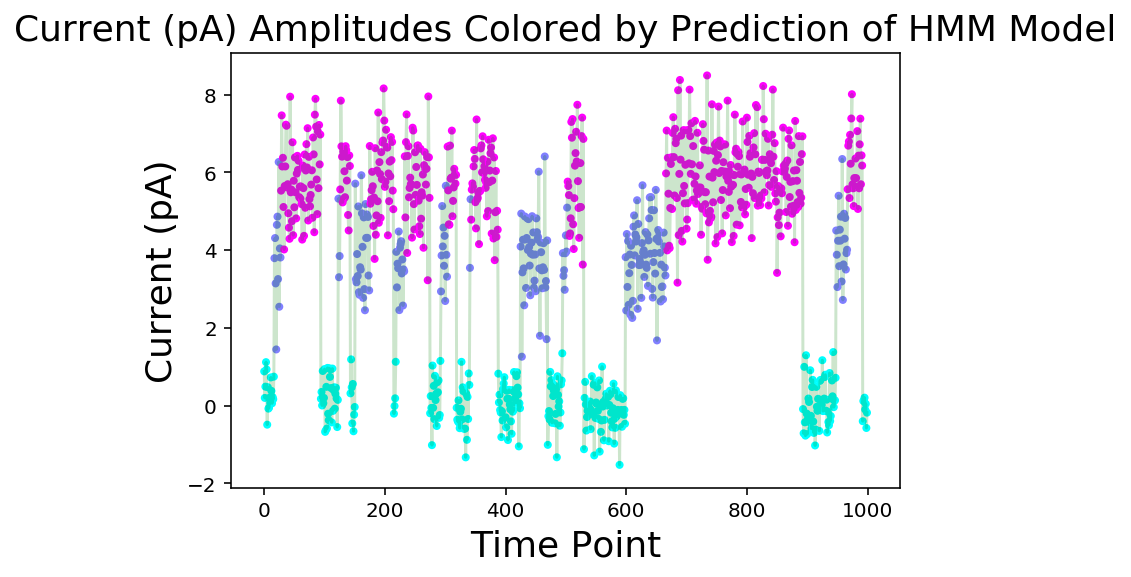

In [24]:
N = 1000
hmm_predicted_state_seq = hmm.predict(current_pA[:N])
#hmm_predicted_state_seq

plt.plot(current_pA[:N],'g-', alpha=0.2)
plt.scatter(range(N), current_pA[:N], marker='.', c=hmm_predicted_state_seq[:N], cmap='cool')
plt.xlabel('Time Point')
plt.ylabel('Current (pA)')
plt.title('Current (pA) Amplitudes Colored by Prediction of HMM Model');

7.  (3 pts) For each transition between different state in the HMM, compute the transition rate constant from the transition probability per time step.

In [16]:
# went to gus' office hours and marcel's office hours

In [17]:
# dont include states where there is no transition, like state 0 and state 0, state 1 and state 1, and state 2 and state 2
# dont include states where the probablity is 0, like between state 2 and state 1
dt_ms = .1
state0_1 = transition_matrix.loc['State0', 'State1']
state0_2 = transition_matrix.loc['State0', 'State2']
state1_0 = transition_matrix.loc['State1', 'State0']
state1_2 = transition_matrix.loc['State1', 'State2']
state2_0 = transition_matrix.loc['State2', 'State0']
# rate = -ln(1-p)/dt_ms
print(f"The rate constant from state 0 to state 1 is {-np.log(1-state0_1)/dt_ms}")
print(f"The rate constant from state 0 to state 2 is {-np.log(1-state0_2)/dt_ms}")
print(f"The rate constant from state 1 to state 0 is {-np.log(1-state1_0)/dt_ms}")
print(f"The rate constant from state 1 to state 2 is {-np.log(1-state1_2)/dt_ms}")
print(f"The rate constant from state 2 to state 0 is {-np.log(1-state2_0)/dt_ms}")

The rate constant from state 0 to state 1 is 0.40613920630889677
The rate constant from state 0 to state 2 is 1.4149792448947727e-10
The rate constant from state 1 to state 0 is 0.1067732243323875
The rate constant from state 1 to state 2 is 0.5191785335556645
The rate constant from state 2 to state 0 is 0.19721764176399303


In [18]:
# p = 1-exp(-rate * dt_ms)
# # tau is time constant.
# p-1 = exp(-rate*dt_ms)
# ln(p-1) = -rate * dt_ms

In [19]:
# hmm_predicted_state_seq = np.array(hmm_predicted_state_seq).T
# idx0 = np.where(hmm_predicted_state_seq == 0)[0]
# idx1 = np.where(hmm_predicted_state_seq == 1)[0]
# idx2 = np.where(hmm_predicted_state_seq == 2)[0]
# hmm_predicted_state_seq[idx2] += 1

# hmm_diff_predicted_state_seq = np.diff(hmm_predicted_state_seq)
# bm = np.where(hmm_diff_predicted_state_seq == 1)[0]
# mu = np.where(hmm_diff_predicted_state_seq == 2)[0]
# ub = np.where(hmm_diff_predicted_state_seq == -3)[0]
# mb = np.where(hmm_diff_predicted_state_seq == -1)[0]

# um_b = np.concatenate((ub,mb))

# closing_starts = ub
# closing_ends = bm[1:]
# N = min(len(closing_starts), len(closing_ends))
# closed_lifetimes_pts =  closing_starts[:N] - closing_ends[:N]

# upper_start = mu
# upper_ends = ub[1:]
# N = min(len(upper_start), len(upper_ends))
# upper_lifetimes_pts = upper_start[:N] - upper_ends[:N]

# middle_start = bm
# middle_ends = mu[:1]
# N = min(len(middle_start), len(middle_ends))
# middle_lifetimes_pts = middle_start[:N] - middle_ends[:N]

In [20]:
# def threeExpoPdf(x,params):
#     A1, tau1, A2, tau2, tau3 = params
#     if A1 + A2 > 1:
#         A12 = A1 + A2
#         A1 /= A12
#         A2 /= A12
#     A3 = 1 - A1 - A2
#     return A1 * st.expon.pdf(times,0,tau1) + A2 * st.expon.pdf(times,0,tau2) + A3 * st.expon.pdf(times,0,tau3)

In [20]:
# upper_lifetime_ms = upper_lifetimes_pts * -.1
# fig, ax = plt.subplots(3)
# binedges = np.linspace(.2,20,31)
# ax[0].hist(upper_lifetime_ms, alpha = .5)


# middle_lifetime_ms = middle_lifetimes_pts * -.1
# binedges = np.linspace(.2,20,31)
# ax[1].hist(middle_lifetime_ms, alpha = .5)

# closed_lifetimes_ms = closed_lifetimes_pts * -.1
# binedges = np.linspace(.2,20,31)
# ax[2].hist(closed_lifetimes_ms, alpha = .5)